# Vanilla GAN for Battery Temperature Generation

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# 1. Generate synthetic temperature data
np.random.seed(42)
num_samples = 500
sequence_length = 50
data = np.array([
    np.sin(np.linspace(0, 2*np.pi, sequence_length)) + np.random.normal(0, 0.1, sequence_length)
    for _ in range(num_samples)
])

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert to tensor
tensor_data = torch.tensor(data_scaled, dtype=torch.float32)

In [3]:
# 2. Dataset & Dataloader
class TempDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

loader = DataLoader(TempDataset(tensor_data), batch_size=32, shuffle=True)

In [4]:
# 3. GAN Models
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),
            nn.Sigmoid()
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

In [5]:
# 4. Initialize
noise_dim = 20
G = Generator(noise_dim, sequence_length)
D = Discriminator(sequence_length)
loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.001)
opt_D = optim.Adam(D.parameters(), lr=0.001)

In [6]:
# 5. Training loop
G_losses, D_losses = [], []
epochs = 10

for epoch in range(epochs):
    for real in loader:
        batch = real.size(0)
        real_labels = torch.ones((batch, 1))
        fake_labels = torch.zeros((batch, 1))

        # Train D
        z = torch.randn(batch, noise_dim)
        fake = G(z).detach()
        loss_real = loss_fn(D(real), real_labels)
        loss_fake = loss_fn(D(fake), fake_labels)
        loss_D = (loss_real + loss_fake) / 2

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train G
        z = torch.randn(batch, noise_dim)
        fake = G(z)
        loss_G = loss_fn(D(fake), real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

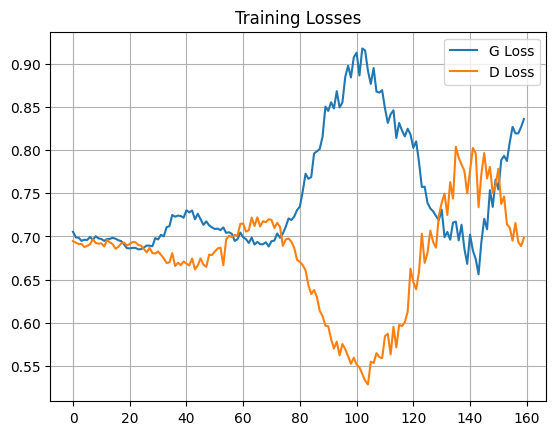

In [7]:
# 6. Plot losses
plt.plot(G_losses, label='G Loss')
plt.plot(D_losses, label='D Loss')
plt.legend()
plt.title('Training Losses')
plt.grid(True)
plt.show()

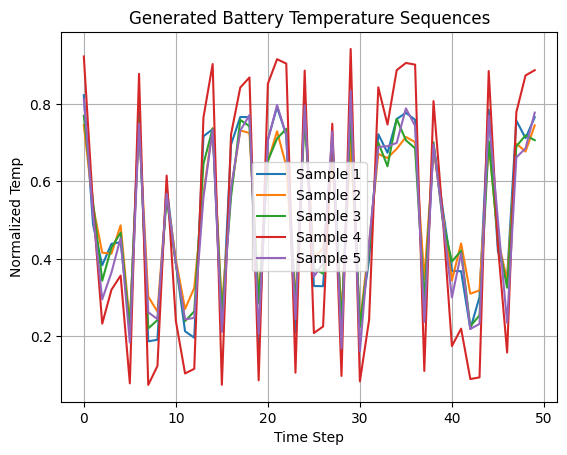

In [8]:
# 7. Plot generated sequences
samples = G(torch.randn(5, noise_dim)).detach().numpy()
for i, s in enumerate(samples):
    plt.plot(s, label=f'Sample {i+1}')
plt.title('Generated Battery Temperature Sequences')
plt.xlabel('Time Step')
plt.ylabel('Normalized Temp')
plt.legend()
plt.grid(True)
plt.show()